# Capítulo 3 - Classificação

## MNIST

Iremos trabalhar encima do MNIST, o conjunto de dados mais clássico para classificação. Consiste em 70 mil pequenas imagens de dígitos escritos a mão.

In [1]:
import numpy as np

In [2]:
# funcao para ordenar o dataset como ele era antigamente
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Os conjuntos de dados carregados pelo scikit-learn geralmente possuem uma estrutura similar ao dicionário, incluindo:

- Uma chave DESCR que descreve o conjunto de dados;
- Uma chave de **dados** que contém um array com uma linha por instância e uma coluna por característica;
- Uma chave alvo contendo um array com rótulos.

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Existem 70 mil imagens e cada imagem possui 784 características. Cada imagem tem 28 x 28 pixels, onde cada característica representa a intensidade de um pixel, variando de 0(branco) até 255(preto).

Vamos pegar um vetor de características de uma instância, remodelá-lo para um array de 28 x 28 e exibi-lo com **imshow()** da biblioteca matplotlib.

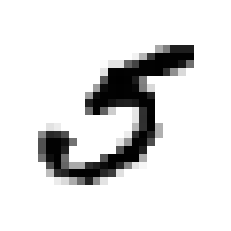

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

De acordo com o rótulo, isso é um 5:

In [6]:
y[36000]

5

O conjunto de dados MNIST já está dividido em um conjunto de treinamento (as primeiras 60 mil imagens) e um conjunto de teste (as últimas 10 mil imagens)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Como os símbolos estão em sequência, iremos embaralhar o conjunto de treinamento para garantir que cada subconjunto de validação possua uma certa heterogeneidade. Isso evita que os algoritmos de treinamento modelem de forma incorreta, ao receberem em sequência muitas instâncias similares.

In [8]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Treinando um Classificador Binário

Vamos começar simplesmente classificando um único simbolo, como o dígito 5.

In [9]:
y_train_5 = (y_train == 5)  # Pegando todos os 5
y_test_5 = (y_test == 5)

Agora vamos escolher um classificador e treiná-lo. "Um bom lugar para começar é com um classificador de Gradiente Descendente Estocástico (SGD, do inglês) com a utilização da classe do scikit-learn". Esse classificador depende da aleatoriedade durante o treinamento (daí o nome "*estocástico*"). É necessário definir o parâmetro **random_state** se desejar resultados reprodutíveis.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

O classificador supôs de forma certeira que a imagem some_digit representa um 5. Agora, avaliaremos o desempenho desse modelo.

### Medições de Desempenho

#### Medindo Acurácia com a Validação Cruzada

Iremos escrever uma implementação da validação cruzada, afim de termos mais controle sobre o processo.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95845
0.9598
0.9566


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.97185, 0.96455, 0.9646 ])

A acurácia do modelo está acima de 95%, isso é muito bom. Porém, isso não quer dizer que o modelo generaliza bem, isso quer dizer que ele conseguiu classificar corretamente uma das classes do conjunto de dados, e a sua medida de acurácia está muito mais relacionada com a quantidade de instâncias dessa classe.

Um classificador simples que tivesse a tarefa de classificar todas imagens que não são o número 5, conseguiria muito facilmente uma acurácia acima de 90%, pois somente 10% das imagens são 5, e com isso, se ela sempre dizer que não é 5, terá no mínimo 90% de acurácia.

Por fim, conclui-se que a acurácia não é a medida mais indicada para avaliar classificadores, especialmente nos casos em que o conjunto de dados é assimétrico, isso é, não possui um balanceamente no número de instâncias em cada classe.

### Matriz de Confusão

A matriz de confusão calcula quantas vezes uma instância da classe A foi classificada com uma instância da classe B.

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53791,   788],
       [ 1192,  4229]])

### Precisão e Revocação

Uma forma de avaliar a classificação de forma mais concisa é por meio da precisão e da revocação. A precisão nada mais é do que a acurácia das previsões positivas. Essa medida é utilizada em conjunto com a revocação (ou sensibilidade), que é a taxa de instâncias positivas que são corretamente detectadas pelo classificador.

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)  # == 4499 / (4499 + 1417)

0.8429340243173211

In [16]:
recall_score(y_train_5, y_train_pred)  # == 4499 / (4499 + 922)

0.7801143700424276

A combinação dessas duas métricas é chamada de *pontuação F1*. Essa pontuação é a *média harmônica* da precisão e revocação. A média harmônica dá muito mais peso aos valores mais baixos. Com isso, o classificador só obterá uma pontuação F1 alta se a revocação e precisão forem altas.

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8103084882161333

### Compensação da Precisão/Revocação

As duas medidas são contrárias no que tange a otimização. Não é possível obter uma precisão e revocação perfeitas, isso se dá devido ao fato de que ao aumentar uma das medidas, a outra invariavelmente irá cair. Para que se aumente a precisão, isso é, o número de verdadeiros positivos, será necessário "apertar" o limiar de decisão do classificador, fazendo assim com que ele seja mais criterioso. Isso consequentemente fará com que o classificador reconheca menos instâncias erradas de uma determinada classe, aumentando assim tanto o verdadeiro positivo, como também o falso negativo, que por sua vez irá diminuir a revocação.

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([393.22260716])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Com limiar 0 o classificador previu a classe corretamente como um 5, vamos aumentar o limiar para comparação.

In [20]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

O classificador detectou quando o limiar era 0, mas não detectou com o limiar 200 mil, isso confirma que aumentar o limiar diminui a revocação.

A fim de descobrir qual o limiar ideal, iremos obter as pontuações de todas as instâncias no conjunto de treinamento, mas dessa vez especificando que deseja que ela retorna as pontuações da decisão em vez das previsões:

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])

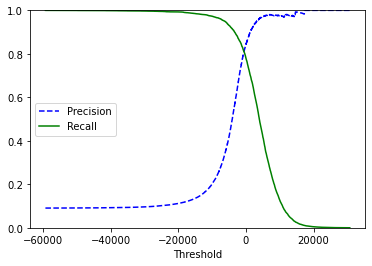

In [24]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### A Curva ROC

A curva das *características operacionais do receptor* (ROC, do inglês) é outra ferramenta comum utilizada com classificadores binários. Essa curva plota a *taxa de verdadeiros positivos* (TPR) versus a *taxa de falsos positivos* (FPR). Essa taxa de falsos positivos é igual a 1 menos a *taxa de verdadeiros negativos* (TNR), que por sua vez é a razão de instâncias negativas que são corretamente classificadas como negativas, e também é chamada de *especificidade*. Portanto, a curva ROC plota a *sensibilidade* versus 1 - *especificidade*.

Para plotar a curva ROC primeiro você precisa calcular a TPR e FPR para vários valores de limiares usando a função roc_curve():

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

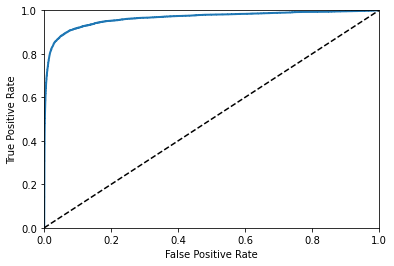

In [27]:
plot_roc_curve(fpr, tpr)
plt.show()

Uma maneira de comparar classificadores é medir a *área abaixo da curva* (AUC, do inglês). Um classificador perfeito terá um ROC AUC igual a 1, enquanto um classificador puramente aleatório terá um ROC AUC igual a 0,5.

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.964296442715093

Você deve preferir a curva precisão/revocação (PR) sempre que a classe positiva for rara ou quando se preocupar mais com os falsos positivos do que com os falsos negativos, e a curva ROC em caso contrário.

Vamos comparar um RandomForestClassifier com o SGDClassifier.

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Como a curva ROC precisa de pontuação e não probabilidades, iremos utilizar a probabilidade da classe positiva como a pontuação:

In [30]:
y_scores_forest = y_probas_forest[:, 1]  # pontuação = probabilidade de classe positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

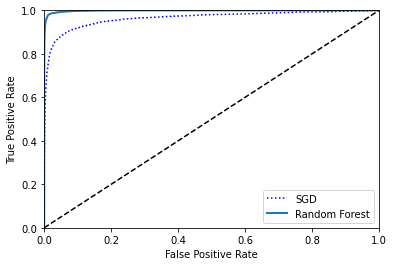

In [31]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [32]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984388491811103

### Classificação Multiclasse

Até agora estávamos classificando em duas classes, 5 e não-5. Agora iremos classificar múltiplas classes de símbolos do MNIST. Existem modelos que trabalham nativamente com múltiplas classes, como Floresta Aleatória ou Naive-Bayes, outros funcionam somente com classificação binária, como o SVM, mas que podem ser utilizados para classificar múltiplas classes a partir de algumas técnicas.

É possível utilizar um classificador binário para classificar múltiplas classes a partir da utilização de diversos classificadores, um para cada classe, avaliando as pontuações de cada um deles e selecionando aquele com a pontuação maior. Isso é chamado de estratégia *um contra todos* (OvA, do inglês).

Existe também como treinar um classificador binário para cada par de dígitos, por exemplo, um para distinguir entre 0s e 1s, outro para 0s e 2s, outro para 1s e 2s e assim por diante. Isso é chamado de estratégia *um contra um* (OvO, do inglês). A principal vantagem dessa abordagem é que cada classificador precisa ser treinado somente para as duas classes que deve distinguir.

Alguns algoritmos, como o SVM, escalam mal com o tamanho do conjunto de treinamento, nesses casos, OvO é melhor, pois é mais rápido treinar muitos classificadores em pequenos conjuntos do que treinar alguns classificadores em grandes conjuntos. Entretanto, OvA é o melhor para a maioria dos algoritmos de classificação binária.

O scikit-learn detecta quando você tenta utilizar um algoritmo de classificação binária para uma tarefa de classificação multiclasse, e automaticamente executa o OvA. Exceto para SVM, nesse caso ele utiliza OvO.

In [33]:
sgd_clf.fit(X_train, y_train)  # y_train, não y_train_5
sgd_clf.predict([some_digit])

array([5], dtype=int8)

Nos bastidores, o scikit-learn treinou 10 classificadores binários, obteve sua pontuação de decisão para a imagem e selecionou a classe com a maior pontuação.

In [34]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -3782.04804647, -18096.09433858,  -9440.31447776,
         -3334.57310407, -20594.62937183,   3361.63325166,
        -27461.71332372, -16160.14748021,  -9194.83934804,
        -18330.88112891]])

In [35]:
np.argmax(some_digit_scores)

5

In [36]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [37]:
sgd_clf.classes_[5]

5

É possível especificar qual das duas estratégias será utilizada:

In [38]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [39]:
len(ovo_clf.estimators_)

45

Treinar um RandomForestClassifier é muito fácil, pois ele é um classificador multiclasse:

In [40]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [41]:
forest_clf.predict_proba([some_digit])

array([[0.03, 0.01, 0.  , 0.02, 0.01, 0.9 , 0.01, 0.  , 0.  , 0.02]])

O classificador tem 85% de confiança de que o número em questão é um 5.

Vamos agora avaliar a precisão utilizando a validação cruzada.

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8537 , 0.8847 , 0.88445])

É possível melhorar a precisão dimensionando as entradas:

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/dystopiandroid/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/dystopiandroid/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([0.90665, 0.9016 , 0.89765])

### Análise de Erro

Depois de encontrar um modelo promissor, é normal querer melhorá-lo, para isso, é importante analisar os erros do sistema. Iremos fazer isso a partir da matriz de confusão.

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

/home/dystopiandroid/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/dystopiandroid/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [45]:
conf_mx

array([[5605,    0,   20,    5,    9,   46,   33,    4,  199,    2],
       [   1, 6420,   46,   22,    4,   42,    5,   11,  180,   11],
       [  28,   28, 5271,   91,   71,   28,   67,   38,  326,   10],
       [  27,   20,  124, 5230,    0,  221,   27,   41,  372,   69],
       [  14,   16,   45,   12, 5239,   11,   38,   19,  286,  162],
       [  29,   19,   31,  160,   52, 4533,   77,   17,  440,   63],
       [  27,   20,   49,    2,   42,   99, 5551,    7,  121,    0],
       [  21,   14,   57,   26,   51,   11,    5, 5719,  151,  210],
       [  18,   65,   41,   99,    4,  126,   33,    9, 5410,   46],
       [  24,   26,   30,   64,  121,   39,    1,  185,  319, 5140]])

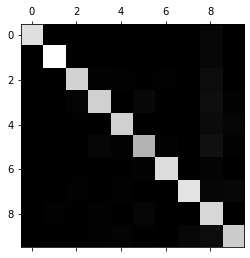

In [46]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Focaremos a plotagem nos erros, Primeiro, você precisa dividir cada valor na matriz de confusão pelo número de imagens na classe correspondente, para que possa comparar as taxas de erro em vez do número absoluto de erros ( o que tornaria as classes mais frequentes parecerem injustamente mal arrumadas):

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Agora, preencheremos a diagonal com zeros para manter apenas os erros e plotar o resultado:

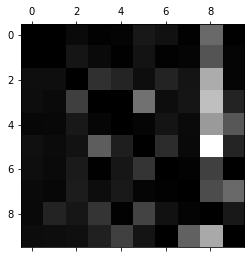

In [48]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

As linhas são as classes reais, as colunas são as classes previstas. As colunas das classes 8 e nova são bem claras, o que quer dizer que muitas imagens estão sendo erroneamente classificadas como 8 ou 9. Da mesma forma, as linhas para as classes 8 e 9 também são muito brilhantes, informando que 8 e 9 geralmente são confundidos com outros dígitos.

Por outro lado, algumas linhas são bastante escuras, como a linha 1: isso significa que a maioria dos 1 são classificados corretamente.

Vamos analisar erros individuais para obter informações sobre o que o nosso classificador está fazendo e por que está falhando.

In [49]:
import matplotlib as mpl
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

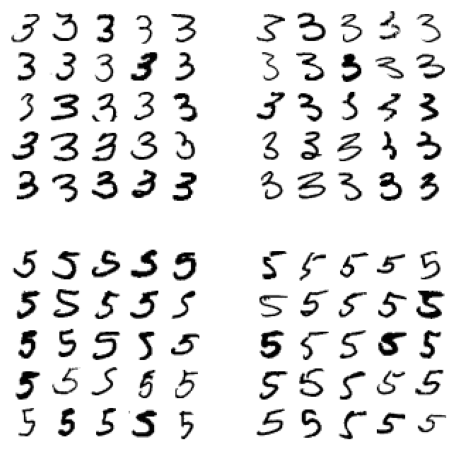

In [50]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Os dois blocos 5 x 5 à esquerda mostram dígitos classificados como 3, e os dois blocos 5 x 5 à direita mostram imagens classificadas como 5.

A razão dos erros é que usamos um SGDClassifier simples, que é um modelo linear. Tudo o que ele faz é atribuir um peso por classe a cada pixel, e, quando ele vê uma nova imagem, apenas resuma as intensidades dos pixels analisados para obter uma pontuação para cada classe. Então, como o 3 e o 5 diferem apenas em alguns pixels, esse modelo facilmente os confundirá.

### Classificação Multilabel

As vezes é necessário classificar mais de um objeto em uma imagem, ou mais de uma característica de um determinado dado. Por exemplo, vamos classificar se o dígito do MNIST é grande (maior que 6) e ímpar.

In [51]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [52]:
knn_clf.predict([some_digit])

array([[False,  True]])

O modelo acertou, isso quer dizer que o dígito 5 não é grande (False) e é ímpar (True).

Para avaliar o modelo, vamos medir a pontuação F1 para cada rótulo individual e calcular a pontuação média.

In [53]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9774550533205185

### Classificação Multioutput

Vamos mostrar agora um tipo de tarefa chamado *multioutput-multiclass*, que é uma generalização da classificação multilabel em que cada rótuo pode ser multiclasse (ou seja, pode ter mais de dois valores possíveis).

Para ilustrar isso, construiremos um sistema que remova o ruído das imagens. Ele tomará como entrada uma imagem numérica ruidosa, e mostrará (espero) uma imagem numérica limpa, representada como um array de intensidade de pixels assim como as imagens MNIST. Observe que a saída do classificador é multilabel (um rótulo por pixel) e cada rótulo pode ter vários valores (a intensidade dos pixels varia de 0 a 255). É,
portanto, um exemplo de um sistema de classificação multioutput.

Vamos começar adicionando ruído nas imagens do MNIST

In [58]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [59]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

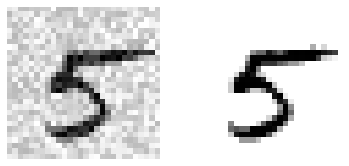

In [61]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

Agora treinaremos o classificador para fazer com que ele limpe esta imagem:

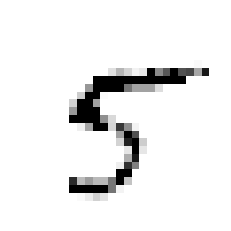

In [62]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)